In [1]:
# Importing Libraries

# Standard libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.gridspec import GridSpec
pd.set_option('display.max_columns', 100)
import json
import requests
import opendatasets as od
from datetime import datetime
import calendar
from pandas.api.types import CategoricalDtype
import warnings
warnings.filterwarnings("ignore")

# Utilities
#from viz_utils import *
#from custom_transformers import *
#from ml_utils import *

# DataPrep
import re
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import joblib

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

In [2]:
#reading datas
import time
start = time.time()
data = pd.read_csv("Data/olist_customers_dataset.csv")
geo_data = pd.read_csv("Data/olist_geolocation_dataset.csv")
order_itemdata = pd.read_csv("Data/olist_order_items_dataset.csv")
pay_data = pd.read_csv("Data/olist_order_payments_dataset.csv")
rev_data = pd.read_csv("Data/olist_order_reviews_dataset.csv")
orders = pd.read_csv("Data/olist_orders_dataset.csv")
order_prddata = pd.read_csv("Data/olist_products_dataset.csv")
order_selldata = pd.read_csv("Data/olist_sellers_dataset.csv")
order_prd_catdata = pd.read_csv("Data/product_category_name_translation.csv")
end = time.time()
print("reading time: ",(end-start),"sec")

reading time:  2.8005828857421875 sec


In [3]:
#checking number of columns , column_names and no_of_rows

datasets = [data,geo_data,order_itemdata, pay_data, orders, order_prddata,rev_data,order_selldata, order_prd_catdata]
titles = ["customers","geolocations","items", "payments", "orders", "products","reviews","sellers","category_translation"]

info_df = pd.DataFrame({},)
info_df['dataset']= titles

info_df['no_of_columns']= [len(df.columns) for df in datasets ]
info_df['columns_name']= [', '.join(list(df.columns)) for df in datasets] 
info_df['no_of_rows'] = [len(df) for df in datasets]

info_df.style.background_gradient(cmap='Greys')

,dataset,no_of_columns,columns_name,no_of_rows
0,customers,5,"customer_id, customer_unique_id, customer_zip_code_prefix, customer_city, customer_state",99441
1,geolocations,5,"geolocation_zip_code_prefix, geolocation_lat, geolocation_lng, geolocation_city, geolocation_state",1000163
2,items,7,"order_id, order_item_id, product_id, seller_id, shipping_limit_date, price, freight_value",112650
3,payments,5,"order_id, payment_sequential, payment_type, payment_installments, payment_value",103886
4,orders,8,"order_id, customer_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date",99441
5,products,9,"product_id, product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm",32951
6,reviews,7,"review_id, order_id, review_score, review_comment_title, review_comment_message, review_creation_date, review_answer_timestamp",99224
7,sellers,4,"seller_id, seller_zip_code_prefix, seller_city, seller_state",3095
8,category_translation,2,"product_category_name, product_category_name_english",71


In [4]:
#checking dtypes
datasets = [data,geo_data,order_itemdata, pay_data, orders, order_prddata,rev_data,order_selldata, order_prd_catdata]
titles = ["customers","geolocations","items", "payments", "orders", "products","reviews","sellers","category_translation"]

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
new_df = pd.DataFrame({},)
new_df['dataset']= titles

new_df['numeric_features'] = [len((df.select_dtypes(include=numerics)).columns) for df in datasets]
new_df['num_features_name'] = [', '.join(list((df.select_dtypes(include=numerics)).columns)) for df in datasets]
new_df['object_features'] = [len((df.select_dtypes(include='object')).columns) for df in datasets]
new_df['objt_features_name'] = [', '.join(list((df.select_dtypes(include='object')).columns)) for df in datasets]
new_df['bool_features'] = [len((df.select_dtypes(include='bool')).columns) for df in datasets]
new_df.style.background_gradient(cmap='Greys')

,dataset,numeric_features,num_features_name,object_features,objt_features_name,bool_features
0,customers,1,customer_zip_code_prefix,4,"customer_id, customer_unique_id, customer_city, customer_state",0
1,geolocations,3,"geolocation_zip_code_prefix, geolocation_lat, geolocation_lng",2,"geolocation_city, geolocation_state",0
2,items,3,"order_item_id, price, freight_value",4,"order_id, product_id, seller_id, shipping_limit_date",0
3,payments,3,"payment_sequential, payment_installments, payment_value",2,"order_id, payment_type",0
4,orders,0,,8,"order_id, customer_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date",0
5,products,7,"product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm",2,"product_id, product_category_name",0
6,reviews,1,review_score,6,"review_id, order_id, review_comment_title, review_comment_message, review_creation_date, review_answer_timestamp",0
7,sellers,1,seller_zip_code_prefix,3,"seller_id, seller_city, seller_state",0
8,category_translation,0,,2,"product_category_name, product_category_name_english",0


In [5]:
#checking no of null values
#code source-https://www.kaggle.com/fayhosseini/brazilian-e-commerce-eda-for-beginners

datasets = [data,geo_data,order_itemdata, pay_data, orders, order_prddata,rev_data,order_selldata, order_prd_catdata]
titles = ["customers","geolocations","items", "payments", "orders", "products","reviews","sellers","category_translation"]

info_df_n = pd.DataFrame({},)

info_df_n['dataset']= titles

#creating column of name of columns in the dataset 
info_df_n['cols'] = [', '.join([col for col, null in df.isnull().sum().items() ]) for df in datasets]

#creating total number of columns in the dataset 
info_df_n['cols_no']= [df.shape[1] for df in datasets]

#counting total null values
info_df_n['null_no']= [df.isnull().sum().sum() for df in datasets]

#creating total number of columns in the dataset with null-values 
info_df_n['null_cols_no']= [len([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]

#creating column of name of columns in the dataset with null-values 
info_df_n['null_cols'] = [', '.join([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]


info_df_n.style.background_gradient(cmap='Greys')

,dataset,cols,cols_no,null_no,null_cols_no,null_cols
0,customers,"customer_id, customer_unique_id, customer_zip_code_prefix, customer_city, customer_state",5,0,0,
1,geolocations,"geolocation_zip_code_prefix, geolocation_lat, geolocation_lng, geolocation_city, geolocation_state",5,0,0,
2,items,"order_id, order_item_id, product_id, seller_id, shipping_limit_date, price, freight_value",7,0,0,
3,payments,"order_id, payment_sequential, payment_type, payment_installments, payment_value",5,0,0,
4,orders,"order_id, customer_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date",8,4908,3,"order_approved_at, order_delivered_carrier_date, order_delivered_customer_date"
5,products,"product_id, product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm",9,2448,8,"product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm"
6,reviews,"review_id, order_id, review_score, review_comment_title, review_comment_message, review_creation_date, review_answer_timestamp",7,145903,2,"review_comment_title, review_comment_message"
7,sellers,"seller_id, seller_zip_code_prefix, seller_city, seller_state",4,0,0,
8,category_translation,"product_category_name, product_category_name_english",2,0,0,


In [6]:
rev_new = rev_data.drop(['review_comment_title','review_creation_date','review_id','review_answer_timestamp'],axis=1)


In [7]:
df = pd.merge(orders,pay_data, on="order_id")
df = df.merge(data, on="customer_id")
df = df.merge(order_itemdata, on="order_id")
df = df.merge(order_prddata, on="product_id")
df = df.merge(order_prd_catdata, on="product_category_name")
df = df.merge(rev_new, on="order_id")
df.head()


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,review_score,review_comment_message
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,credit_card,1,18.12,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,4,"Não testei o produto ainda, mas ele veio corre..."
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,3,voucher,1,2.00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,4,"Não testei o produto ainda, mas ele veio corre..."
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,2,voucher,1,18.59,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,4,"Não testei o produto ainda, mas ele veio corre..."
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28 00:00:00,1,credit_card,3,37.77,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-21 20:05:16,29.99,7.78,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,4,Deveriam embalar melhor o produto. A caixa vei...
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15 00:00:00,1,credit_card,1,37.77,ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-08 18:37:31,29.99,7.78,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,5,"Só achei ela pequena pra seis xícaras ,mais é ..."


In [8]:
print("Number of rows after merging:",len(df))
print("Number of columns after merging:",len(df.columns))

Number of rows after merging: 115609
Number of columns after merging: 33


In [9]:
df.isnull().sum()

order_id                             0
customer_id                          0
order_status                         0
order_purchase_timestamp             0
order_approved_at                   14
order_delivered_carrier_date      1195
order_delivered_customer_date     2400
order_estimated_delivery_date        0
payment_sequential                   0
payment_type                         0
payment_installments                 0
payment_value                        0
customer_unique_id                   0
customer_zip_code_prefix             0
customer_city                        0
customer_state                       0
order_item_id                        0
product_id                           0
seller_id                            0
shipping_limit_date                  0
price                                0
freight_value                        0
product_category_name                0
product_name_lenght                  0
product_description_lenght           0
product_photos_qty       

In [10]:
#Handling missing values
index = (df[df['order_delivered_customer_date'].isnull() == True].index.values)

df["order_approved_at"].fillna(df["order_purchase_timestamp"], inplace=True)
df["order_delivered_customer_date"].fillna(df["order_estimated_delivery_date"], inplace=True)

#dropping order delivery carrier date
df.drop(labels='order_delivered_carrier_date',axis=1,inplace=True)

In [11]:
#checking the replaced values
df.order_estimated_delivery_date[index[0]]

'2017-07-06 00:00:00'

In [12]:
df.order_delivered_customer_date[index[0]]

'2017-07-06 00:00:00'

In [13]:
# Handling missing values of numerical features
df['product_weight_g'].fillna(df['product_weight_g'].median(),inplace=True)
df['product_length_cm'].fillna(df['product_length_cm'].median(),inplace=True)
df['product_height_cm'].fillna(df['product_height_cm'].median(),inplace=True)
df['product_width_cm'].fillna(df['product_width_cm'].median(),inplace=True)

In [14]:
#Handling missing values of text column
print("Percentage of null reviews :",(df.review_comment_message.isnull().sum()/len(df))*100 ,"%")
# filling null value of review comments with no_review
df['review_comment_message'].fillna('nao_reveja',inplace=True)

Percentage of null reviews : 57.697065107387836 %


In [15]:
dup_rows = df[df.duplicated(['order_id','customer_id','order_purchase_timestamp','order_delivered_customer_date','customer_unique_id','review_comment_message'])]
dup_rows.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,review_score,review_comment_message
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18 00:00:00,3,voucher,1,2.00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,4,"Não testei o produto ainda, mas ele veio corre..."
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18 00:00:00,2,voucher,1,18.59,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,4,"Não testei o produto ainda, mas ele veio corre..."
8,82bce245b1c9148f8d19a55b9ff70644,388025bec8128ff20ec1a316ed4dcf02,delivered,2017-04-20 17:15:46,2017-04-21 05:15:56,2017-05-10 09:17:55,2017-05-12 00:00:00,1,boleto,1,267.80,f9effeed3df9ae063a58c0759b96f8b2,85804,cascavel,PR,2,a5a0e71a81ae65aa335e71c06261e260,c8417879a15366a17c30af34c798c332,2017-04-27 05:15:56,38.00,15.56,utilidades_domesticas,57.0,698.0,3.0,705.0,34.0,22.0,28.0,housewares,1,nao_reveja
9,82bce245b1c9148f8d19a55b9ff70644,388025bec8128ff20ec1a316ed4dcf02,delivered,2017-04-20 17:15:46,2017-04-21 05:15:56,2017-05-10 09:17:55,2017-05-12 00:00:00,1,boleto,1,267.80,f9effeed3df9ae063a58c0759b96f8b2,85804,cascavel,PR,3,a5a0e71a81ae65aa335e71c06261e260,c8417879a15366a17c30af34c798c332,2017-04-27 05:15:56,38.00,15.56,utilidades_domesticas,57.0,698.0,3.0,705.0,34.0,22.0,28.0,housewares,1,nao_reveja
10,82bce245b1c9148f8d19a55b9ff70644,388025bec8128ff20ec1a316ed4dcf02,delivered,2017-04-20 17:15:46,2017-04-21 05:15:56,2017-05-10 09:17:55,2017-05-12 00:00:00,1,boleto,1,267.80,f9effeed3df9ae063a58c0759b96f8b2,85804,cascavel,PR,4,a5a0e71a81ae65aa335e71c06261e260,c8417879a15366a17c30af34c798c332,2017-04-27 05:15:56,38.00,15.56,utilidades_domesticas,57.0,698.0,3.0,705.0,34.0,22.0,28.0,housewares,1,nao_reveja


In [16]:
#Deduplication of entries
df= df.drop_duplicates(subset={'order_id','customer_id','order_purchase_timestamp','order_delivered_customer_date'}, keep='first', inplace=False)
df=df.reindex()
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,review_score,review_comment_message
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18 00:00:00,1,credit_card,1,18.12,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,4,"Não testei o produto ainda, mas ele veio corre..."
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-18 14:44:43,2017-08-28 00:00:00,1,credit_card,3,37.77,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-21 20:05:16,29.99,7.78,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,4,Deveriam embalar melhor o produto. A caixa vei...
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-07 18:30:01,2017-08-15 00:00:00,1,credit_card,1,37.77,ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-08 18:37:31,29.99,7.78,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,5,"Só achei ela pequena pra seis xícaras ,mais é ..."
5,bfc39df4f36c3693ff3b63fcbea9e90a,53904ddbea91e1e92b2b3f1d09a7af86,delivered,2017-10-23 23:26:46,2017-10-25 02:14:11,2017-11-07 18:04:59,2017-11-13 00:00:00,1,boleto,1,44.09,e781fdcc107d13d865fc7698711cc572,88032,florianopolis,SC,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-31 02:14:11,29.99,14.10,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,3,nao_reveja
6,6ea2f835b4556291ffdc53fa0b3b95e8,c7340080e394356141681bd4c9b8fe31,delivered,2017-11-24 21:27:48,2017-11-25 00:21:09,2017-12-28 18:59:23,2017-12-21 00:00:00,1,credit_card,10,356.12,3e4fd73f1e86b135b9b121d6abbe9597,19400,presidente venceslau,SP,1,be021417a6acb56b9b50d3fd2714baa8,f5f46307a4d15880ca14fab4ad9dfc9b,2017-11-30 00:21:09,339.00,17.12,utilidades_domesticas,48.0,664.0,6.0,14300.0,38.0,34.0,34.0,housewares,1,"Inicialmente, na data da compra o produto era ..."


In [17]:
print("Number of rows after dedublication:",len(df))
print("Number of columns after deduplication:",len(df.columns))

Number of rows after dedublication: 96516
Number of columns after deduplication: 32


In [18]:
# all time stamps are in object dtype as observed above converting it into dataetime 
df[['order_purchase_timestamp','order_approved_at','order_delivered_customer_date','order_estimated_delivery_date',]]=df[['order_purchase_timestamp',
       'order_approved_at','order_delivered_customer_date','order_estimated_delivery_date']].apply(pd.to_datetime)



In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96516 entries, 0 to 115608
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       96516 non-null  object        
 1   customer_id                    96516 non-null  object        
 2   order_status                   96516 non-null  object        
 3   order_purchase_timestamp       96516 non-null  datetime64[ns]
 4   order_approved_at              96516 non-null  datetime64[ns]
 5   order_delivered_customer_date  96516 non-null  datetime64[ns]
 6   order_estimated_delivery_date  96516 non-null  datetime64[ns]
 7   payment_sequential             96516 non-null  int64         
 8   payment_type                   96516 non-null  object        
 9   payment_installments           96516 non-null  int64         
 10  payment_value                  96516 non-null  float64       
 11  customer_uniqu

In [20]:
df.describe()

,payment_sequential,payment_installments,payment_value,customer_zip_code_prefix,order_item_id,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,review_score
count,96516.000000,96516.000000,96516.000000,96516.000000,96516.000000,96516.000000,96516.000000,96516.000000,96516.000000,96516.000000,96516.000000,96516.000000,96516.000000,96516.000000,96516.000000
mean,1.022545,2.919858,157.924421,35163.974543,1.016205,125.777851,20.220468,48.846253,794.118188,2.251015,2106.227133,30.147955,16.507771,23.061855,4.107412
std,0.247935,2.711997,216.773702,29810.746531,0.145692,189.535209,15.931328,9.995674,654.863686,1.746647,3764.648279,16.154906,13.339701,11.744019,1.329213
min,1.000000,0.000000,0.010000,1003.000000,1.000000,0.850000,0.000000,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000,1.000000
25%,1.000000,1.000000,60.065000,11368.750000,1.000000,41.900000,13.300000,42.000000,349.000000,1.000000,300.000000,18.000000,8.000000,15.000000,4.000000
50%,1.000000,2.000000,103.190000,24422.000000,1.000000,79.000000,16.390000,52.000000,607.000000,2.000000,700.000000,25.000000,13.000000,20.000000,5.000000
75%,1.000000,4.000000,175.392500,59015.000000,1.000000,139.900000,21.260000,57.000000,996.000000,3.000000,1813.000000,38.000000,20.000000,30.000000,5.000000
max,27.000000,24.000000,13664.080000,99980.000000,7.000000,6735.000000,409.680000,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.000000,5.000000


In [21]:
# checking the target variables i.e review score 
df.review_score.value_counts()

5    56185
4    18732
1    10598
3     7978
2     3023
Name: review_score, dtype: int64

In [22]:
def partition(x):
    if x < 3:
        return 0
    return 1
df['review_score']=df['review_score'].map(lambda cw : partition(cw) ) 
    
# checking the review score now
df.review_score.value_counts()

1    82895
0    13621
Name: review_score, dtype: int64

Total Positive Reviews : 82895 , ( 85.8873140204733 %)
Total Negative Reviews : 13621 , ( 14.11268597952671 %)




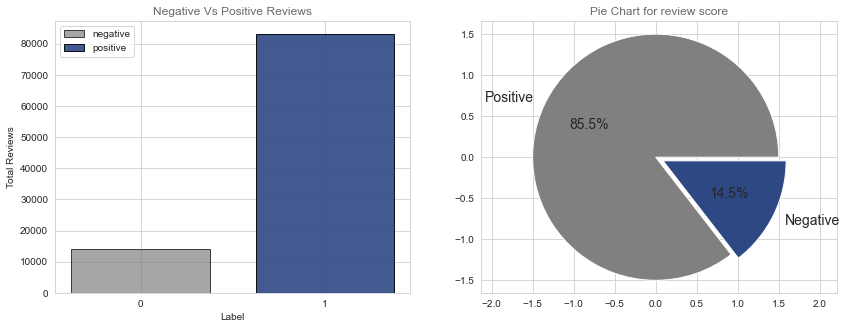

In [23]:
#counting the review score with 1 and 0
y_value_counts = df.review_score.value_counts()

#calculating the percentage of each review type
print("Total Positive Reviews :", y_value_counts[1], ", (", (y_value_counts[1]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")
print("Total Negative Reviews :", y_value_counts[0], ", (", (y_value_counts[0]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")
print('\n')

#plotting bar-plot and pie chart
%matplotlib inline
sns.set_style("whitegrid")
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.ylabel('Total Reviews')
plt.xlabel('Label')
plt.title('Negative Vs Positive Reviews',color='dimgrey')
plt.xticks([10,10.20],['0','1'])
#creating bar plots
plt.bar(10,14112, color = 'grey', width = 0.15,alpha=0.7,label='negative',edgecolor='black')
plt.bar(10.20,83143,color = '#2e4884', width = 0.15,alpha=0.9,label='positive',edgecolor='black')
plt.legend()

plt.subplot(1,2,2)
labels = ['Positive','Negative']
sizes = [83143,14112]
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')
color={'#2e4884','grey'}
plt.pie(sizes,explode=explode ,colors=color,labels=labels, autopct='%1.1f%%',shadow=False, startangle=0,radius=1.5,labeldistance=1.1,textprops={'fontsize': 14},frame=True, )
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Pie Chart for review score',color='dimgrey')
plt.show()


In [24]:
df.to_csv("Data/olist_shop_cleaned_data2.csv")

In [25]:
#Correlation matrix 
corr_matrix = df.corr()

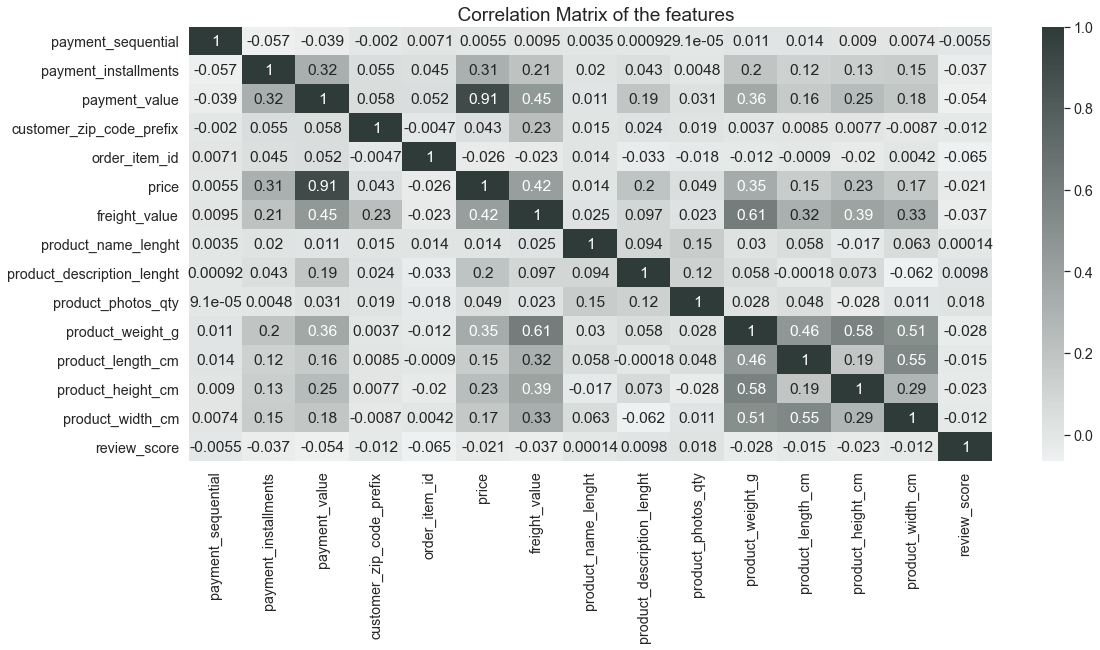

In [26]:
plt.figure(figsize=(18,8))
sns.set(font_scale=1.3)
cmap = sns.light_palette("#2f3b39",as_cmap=True)
sns.heatmap(corr_matrix, cmap=cmap,annot=True)
plt.title("  Correlation Matrix of the features",fontsize=19)
plt.savefig('plot16.png', dpi=300, bbox_inches='tight')
plt.show()

In [27]:
#finding corr- values of the features with review_score
corr_matrix["review_score"].sort_values(ascending=False)

review_score                  1.000000
product_photos_qty            0.018062
product_description_lenght    0.009772
product_name_lenght           0.000142
payment_sequential           -0.005510
product_width_cm             -0.011653
customer_zip_code_prefix     -0.012370
product_length_cm            -0.015065
price                        -0.021429
product_height_cm            -0.023263
product_weight_g             -0.028432
freight_value                -0.036847
payment_installments         -0.037339
payment_value                -0.053558
order_item_id                -0.065218
Name: review_score, dtype: float64

In [28]:
#checking unique ids
print("Total number of unique seller_id:",len((df.seller_id).unique()))
print("Total number of unique product_id:",len((df.product_id).unique()))
print("Total number of unique customer_id:",len((df.customer_unique_id).unique()))

Total number of unique seller_id: 3017
Total number of unique product_id: 30905
Total number of unique customer_id: 93396


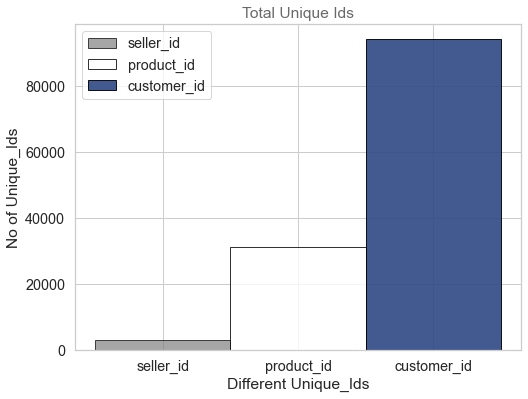

In [29]:
%matplotlib inline
plt.figure(figsize=(8,6))
sns.set_style("whitegrid")
plt.ylabel('No of Unique_Ids')
plt.xlabel('Different Unique_Ids')
plt.title('Total Unique Ids',color='dimgrey')
plt.xticks([10,10.25,10.50],['seller_id','product_id','customer_id'])
#creating bar plots
plt.bar(10,3022, color = 'grey', width = 0.25,alpha=0.7,label='seller_id',edgecolor='black')
plt.bar(10.25,31053, color = 'white', width = 0.25,alpha=0.8,label='product_id',edgecolor='black')
plt.bar(10.50,94087, color = '#2e4884', width = 0.25,alpha=0.9,label='customer_id',edgecolor='black')
plt.legend()
plt.show()

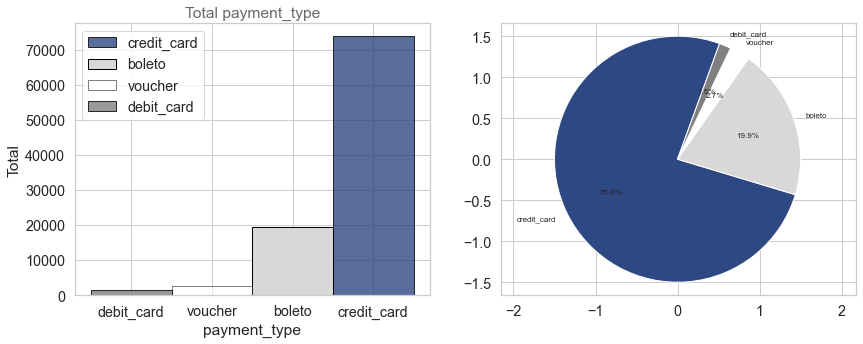

In [30]:
%matplotlib inline
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.ylabel('Total')
plt.xlabel('payment_type')
plt.title('Total payment_type',color='dimgrey')
plt.xticks([10,10.25,10.50,10.75],['debit_card','voucher','boleto','credit_card'])
#creating bar plots
plt.bar(10.75,73816, color = '#2e4884', width = 0.25,alpha=0.8,label='credit_card',edgecolor='black')
plt.bar(10.50,19345, color = '#d8d8d8', width = 0.25,label='boleto',edgecolor='black')
plt.bar(10.25,2604, color = 'white', width = 0.25,alpha=0.5,label='voucher',edgecolor='black')
plt.bar(10,1490, color = 'grey', width = 0.25,alpha=0.8,label='debit_card',edgecolor='black')



plt.legend()

plt.subplot(1,2,2)
s= [ 73816,19345, 2604,1490]
new = ['credit_card','boleto','voucher','debit_card']

explode = (0, 0, 0,0)  
colours = {'credit_card': '#2e4884',
           'boleto': '#d8d8d8',
           'voucher': 'w',
           'debit_card': 'grey'}

color ={'#2e4884','grey','#d8d8d8','w'}



plt.pie(s, explode=explode, labels=new,colors=[colours[key] for key in new] , autopct='%1.1f%%',shadow=False, startangle=70,radius=1.5,frame=True,textprops={'fontsize': 8})
plt.axis('equal') 
plt.show()


In [31]:
temp = pd.DataFrame(df.groupby('payment_type')['review_score'].agg(lambda x: x.eq(1).sum())).reset_index()

# Pandas dataframe grouby count: https://stackoverflow.com/a/19385591/4084039
temp['total'] = list(pd.DataFrame(df.groupby('payment_type')['review_score'].agg([('total','count'),('Avg','mean')]))['total'])
temp['Avg']   = list(pd.DataFrame(df.groupby('payment_type')['review_score'].agg([('total','count'),('Avg','mean')]))['Avg'])
#sorting dataframe
temp = temp.sort_values(by=['total'], ascending=True)

In [32]:
#Simplifing the plots using pareto plots
def pareto_plot(df, x=None, y=None, title=None, show_pct_y=False, pct_format='{0:.0%}'):
    xlabel = x
    ylabel = y
    tmp = df.sort_values(y, ascending=False)
    x = tmp[x].values
    y = tmp[y].values
    weights = y / y.sum()
    cumsum = weights.cumsum()

    fig, ax1 = plt.subplots(figsize=(10,6))
    ax1.bar(x, y,color='#2e4884',edgecolor='black',alpha=0.9)
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)

    ax2 = ax1.twinx()
    ax2.plot(x, cumsum, '-ro', alpha=0.5,color='black')
    ax2.set_ylabel('', color='r')
    ax2.tick_params('y', colors='r')
    
    vals = ax2.get_yticks()
    ax2.set_yticklabels(['{:,.2%}'.format(x) for x in vals])

    # hide y-labels on right side
    if not show_pct_y:
        ax2.set_yticks([])
    
    formatted_weights = [pct_format.format(x) for x in cumsum]
    for i, txt in enumerate(formatted_weights):
        ax2.annotate(txt, (x[i], cumsum[i]),fontsize=15)    
    
    if title:
        plt.title(title,color='dimgrey',fontsize=15)
    
    plt.tight_layout()
    plt.show()

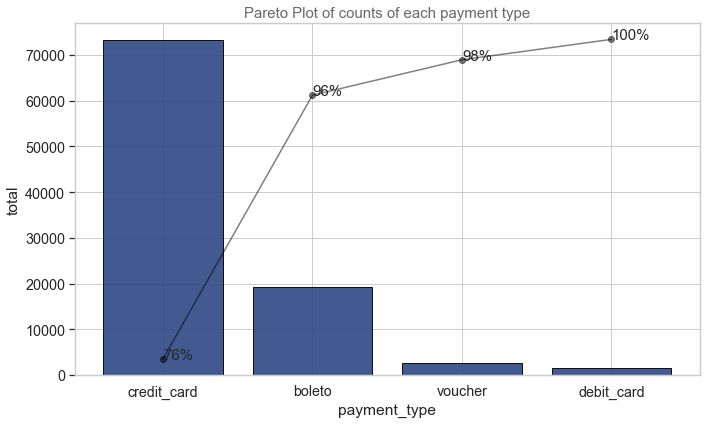

In [33]:
pareto_plot(temp,x='payment_type',y='total',title="Pareto Plot of counts of each payment type")

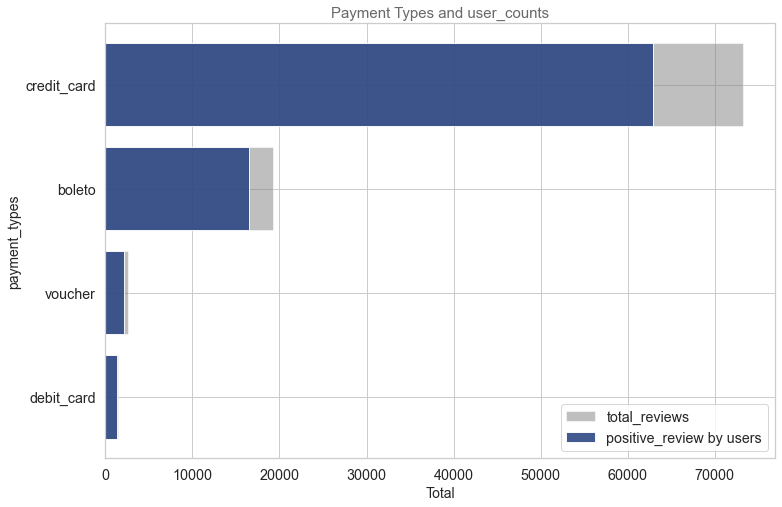

In [34]:
#Let us see how this categorical feature related with our target variable
#code source-https://matplotlib.org/stable/gallery/lines_bars_and_markers/barh.html
plt.figure(figsize=(12,8))
p1=plt.barh(temp.payment_type,temp.total,color='grey',alpha=0.5)
p2=plt.barh(temp.payment_type,temp.review_score,color='#2e4884',alpha=0.9)
plt.title('Payment Types and user_counts',fontsize=15,color='dimgrey')
plt.ylabel('payment_types',fontsize=14)
plt.xlabel('Total',fontsize=14)
plt.legend((p1[0], p2[0]), ('total_reviews', 'positive_review by users'))

plt.show()

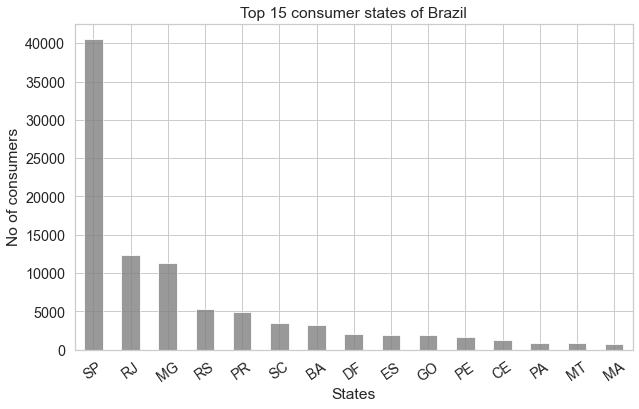

In [35]:
# State with the consumers count
plt.figure(figsize=(10,6))
sns.set_style("whitegrid")
ax = df.customer_state.value_counts().sort_values(ascending=False)[0:15].plot(kind='bar', color = 'grey', alpha=0.8)
ax.set_title("Top 15 consumer states of Brazil")
ax.set_xlabel("States")
plt.xticks(rotation=35)
ax.set_ylabel("No of consumers")
plt.show()

Observation(s):

* 42% of total consumers are from the SP(São Paulo), 12.9 % are from RJ(Rio de Janeiro) and 11.7 % are from MG(Minas Gerais) which means most of consumers are from these states.Also from the above map we can observe these are neighbouring staes these staes are most active.Now, Let us see what type of reviews are given from the consumer of these states.




In [36]:
#stacked bar plots matplotlib: https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html
def stack_plot(data, xtick, col2, col3='total'):
    ind = np.arange(data.shape[0])
    
    plt.figure(figsize=(20,5))
    p1 = plt.bar(ind, data[col3].values,color = 'grey',alpha=0.5)
    p2 = plt.bar(ind, data[col2].values,color= '#2e4884',alpha=0.8)

    plt.ylabel('Reviews')
    plt.title('% of review_score  ')
    plt.xticks(ind-0.1, list(data[xtick].values), rotation=0)
    plt.legend((p1[0], p2[0]), ('total_reviews', 'positive_review'))
    plt.show()

In [37]:
# Count number of zeros in dataframe python: https://stackoverflow.com/a/51540521/4084039
temp_1 = pd.DataFrame(df.groupby('customer_state')['review_score'].agg(lambda x: x.eq(1).sum())).reset_index()

# Pandas dataframe grouby count: https://stackoverflow.com/a/19385591/4084039


temp_1['total'] = list(pd.DataFrame(df.groupby('customer_state')['review_score'].agg([('total','count'),('Avg','mean')]))['total'])
temp_1['Avg']   = list(pd.DataFrame(df.groupby('customer_state')['review_score'].agg([('total','count'),('Avg','mean')]))['Avg'])
temp_1= temp_1.rename(columns={'review_score':'positive_review'})
temp_1= temp_1.sort_values(by=['total'], ascending=False)

In [38]:
temp_1

,customer_state,positive_review,total,Avg
25,SP,35697,40536,0.880625
18,RJ,9907,12410,0.798308
10,MG,9851,11297,0.872001
22,RS,4641,5331,0.870568
17,PR,4319,4902,0.881069
23,SC,3031,3526,0.859614
4,BA,2671,3277,0.815075
6,DF,1779,2084,0.853647
7,ES,1694,1981,0.855124
8,GO,1668,1946,0.857143


Observation(s):

* From the avove stack plot of reviews per state we can conclude that most of consumers from each state has given positive reviews.In **SP** state from the total reviews of 40800 , 35791 reviews are positive reviews and for **RJ** state 9968 reviews are positive from the total reviews 12569.The consumer_state can be our important feature for the problem.



## 3.2.2 Univariate Analysis: product_category_name_english

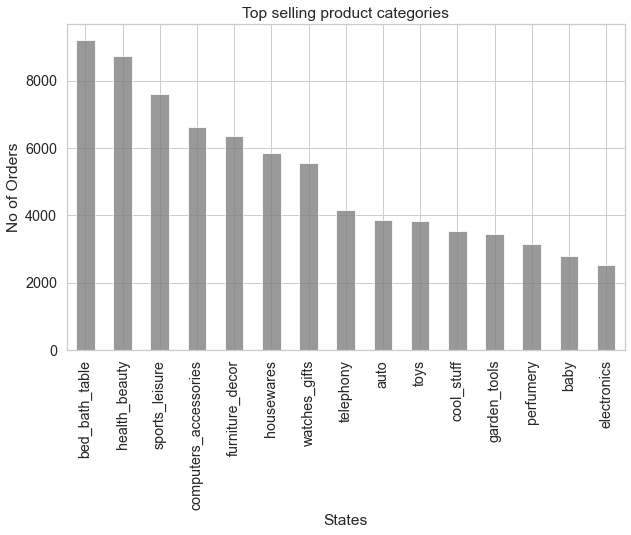

In [39]:
# State with the consumers count
plt.figure(figsize=(10,6))
sns.set_style("whitegrid")
ax = df.product_category_name_english.value_counts().sort_values(ascending=False)[0:15].plot(kind='bar', color = 'grey', alpha=0.8)
ax.set_title("Top selling product categories")
ax.set_xlabel("States")
plt.xticks(rotation=90)
ax.set_ylabel("No of Orders")
plt.show()

In [40]:
  temp_2 = pd.DataFrame(df.groupby('product_category_name_english')['review_score'].agg(lambda x: x.eq(1).sum())).reset_index()

  # Pandas dataframe grouby count: https://stackoverflow.com/a/19385591/4084039


  temp_2['total'] = list(pd.DataFrame(df.groupby('product_category_name_english')['review_score'].agg([('total','count'),('Avg','mean')]))['total'])
  temp_2['Avg']   = list(pd.DataFrame(df.groupby('product_category_name_english')['review_score'].agg([('total','count'),('Avg','mean')]))['Avg'])
  temp_2 = temp_2.sort_values(by=['total'], ascending=True)
  temp_2

,product_category_name_english,review_score,total,Avg
61,security_and_services,1,2,0.500000
29,fashion_childrens_clothes,5,6,0.833333
52,la_cuisine,10,11,0.909091
11,cds_dvds_musicals,12,12,1.000000
3,arts_and_craftmanship,19,21,0.904762
...,...,...,...,...
39,furniture_decor,5310,6366,0.834119
15,computers_accessories,5569,6627,0.840350
65,sports_leisure,6639,7613,0.872061
43,health_beauty,7631,8732,0.873912


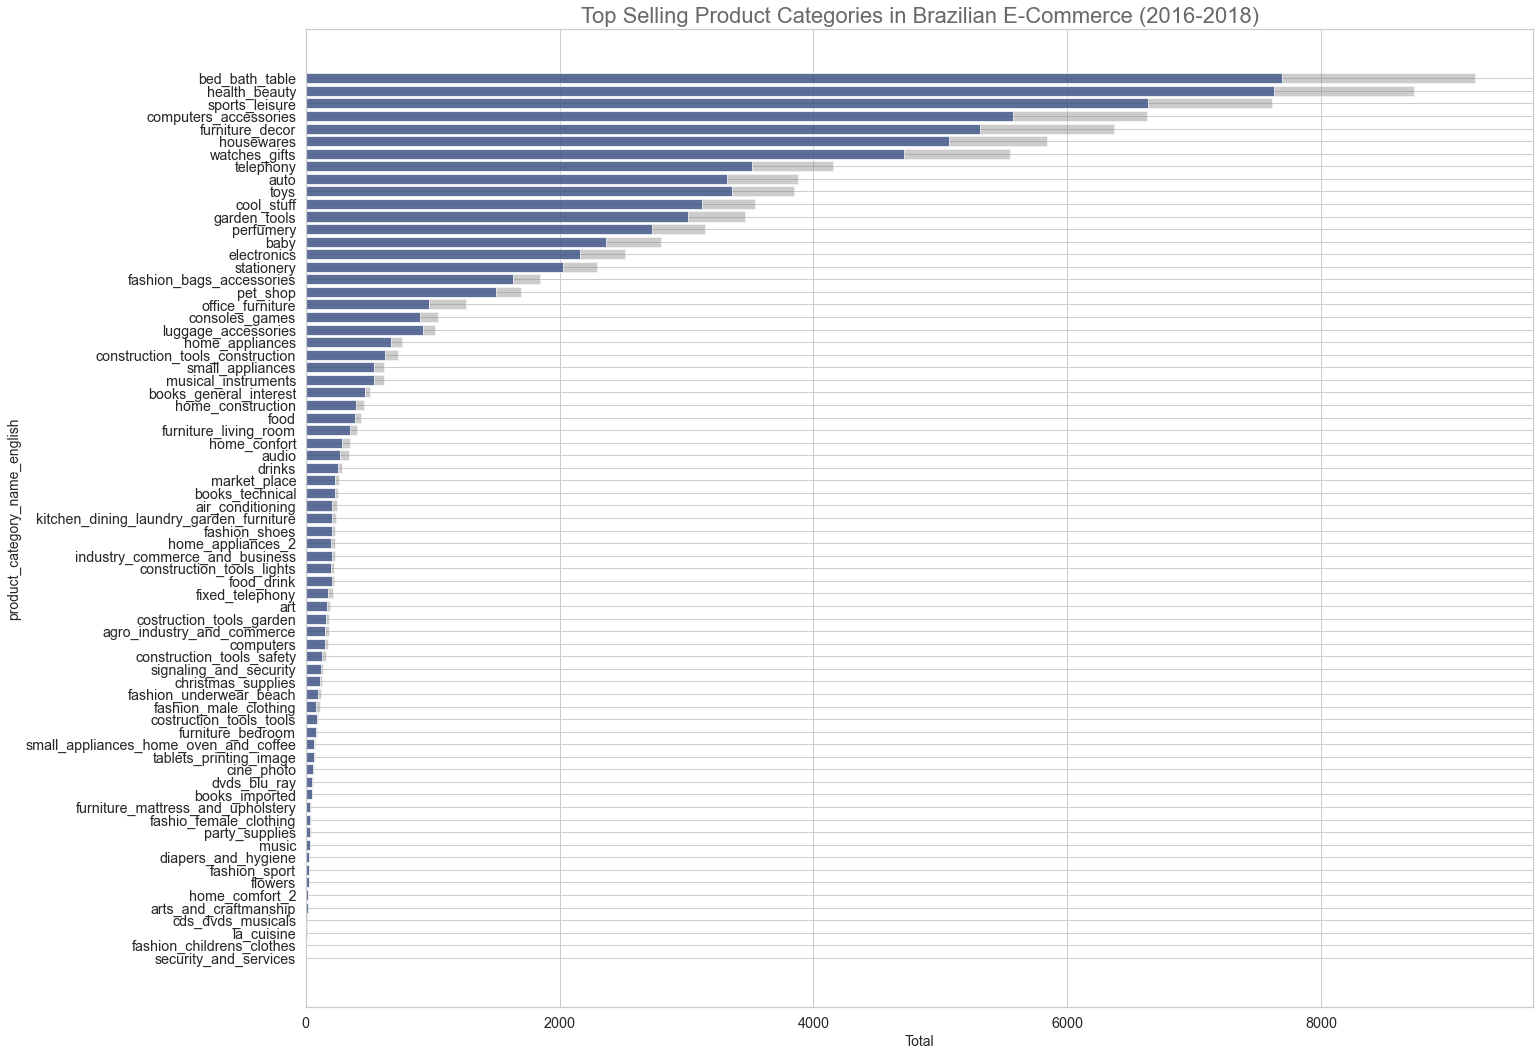

In [41]:
#code source-https://matplotlib.org/stable/gallery/lines_bars_and_markers/barh.html
plt.figure(figsize=(22,18))
plt.barh(temp_2.product_category_name_english,temp_2.total,color='grey',alpha=0.4)
plt.barh(temp_2.product_category_name_english,temp_2.review_score,color='#2e4884',alpha=0.7)
plt.title('Top Selling Product Categories in Brazilian E-Commerce (2016-2018)',fontsize=22,color='dimgrey')
plt.ylabel('product_category_name_english',fontsize=14)
plt.xlabel('Total',fontsize=14)
plt.savefig('plot14.png', dpi=480, bbox_inches='tight')
plt.show()

Observation(s):
* From the first plot titled  Top selling product categories we can conclude that most ordered products is from bed_bath_table category ,health beauty and sports_leisure between 2016 and 2018.The least ordered products are from security_and_services.

* The second plot is stack plot which shows the total reviews and the reviews with positive sense.from this plot we can conclude that most of the reviews for the product category bed_bath_table are positive and it is same for the other product categories.This can be our important categorical feature for the problem.

Text(0.5, 1.0, 'Number of orders per customer')

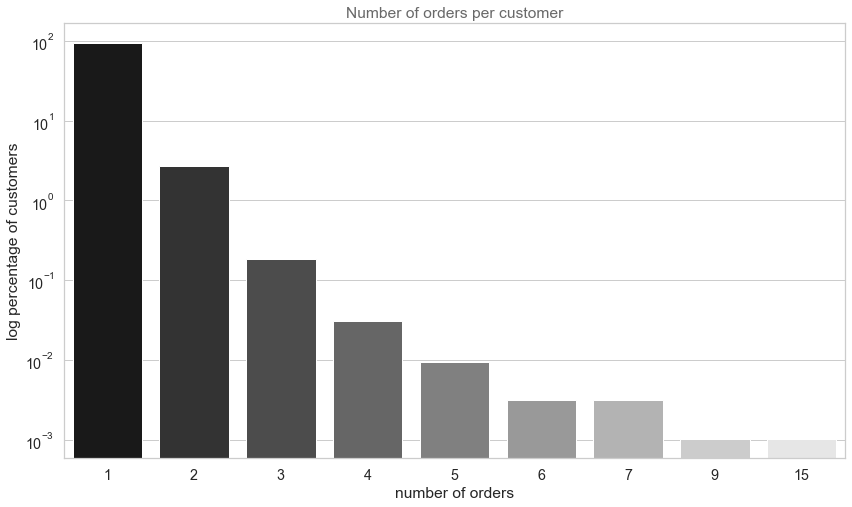

In [42]:
# plotting frequency orders vs  the number of consumers 
plt.figure(figsize=(14,8))

#counting the consumers and converting it into percentage to visualize the distribution properly
num_orders=df['customer_unique_id'].value_counts().value_counts()/df.shape[0]*100
num_orders=num_orders.reset_index()
#renaming the columns
num_orders.rename(columns={'index':'number of orders', 'customer_unique_id':'log percentage of customers'},inplace=True)

#plotting bar plot
sns.barplot(data=num_orders,x='number of orders',y='log percentage of customers',palette='gray')
plt.yscale('log') #log scale
plt.title('Number of orders per customer',color='dimgrey')

Observation(s):
* Most of the consumer given order of any  products only for  one times and few consumers are also present who oredred products more than 35 times. From this we can say order frequecy can be used as important feature for the problem.

### 3.2.2 Univariate Analysis: Order_status

NameError: name 'countplot' is not defined

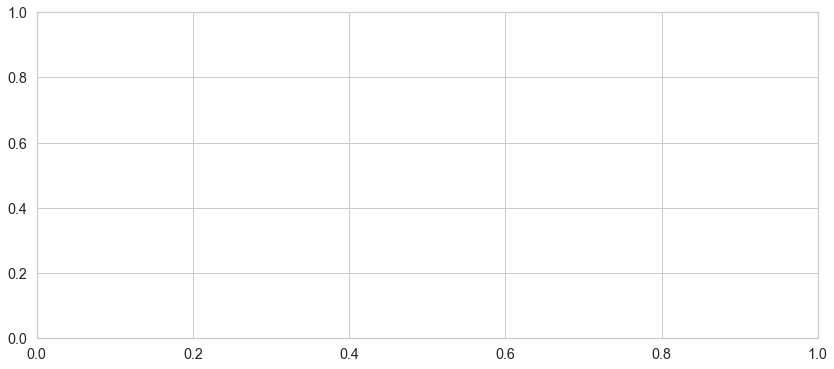

In [43]:
#by using custom countplots in (viz_utils)
fig, ax = plt.subplots(figsize=(14, 6))
countplot(df, x='order_status', ax=ax,palette=['grey'])
plt.title('Order_status',color='dimgrey')
plt.show()

In [ ]:
#by using custom countplots in (viz_utils)
fig, ax = plt.subplots(figsize=(14, 6))
single_countplot(df, x='order_status', ax=ax,palette=['grey','#425a90'],hue='review_score')
plt.title('Order_status with % of Reviews',color='dimgrey')
plt.show()

In [ ]:
#calulating number of days for the data is taken
print(df.order_approved_at.max() - df.order_approved_at.min(), ' from ', 
      df.order_approved_at.min(), ' to ', df.order_approved_at.max())

In [ ]:
#code source-https://stackoverflow.com/questions/25146121/extracting-just-month-and-year-separately-from-pandas-datetime-column

# Extracting attributes for purchase date - Year and Month
df['order_purchase_year'] = df['order_purchase_timestamp'].apply(lambda x: x.year) #gives year Example :2016-10-04 09:43:32 ---->2016
df['order_purchase_month'] = df['order_purchase_timestamp'].apply(lambda x: x.month) #gives month Example :2016-10-04 09:43:32 ---->10
df['order_purchase_month_name'] = df['order_purchase_timestamp'].apply(lambda x: x.strftime('%b'))#gives month in short form Example :2016-10-04 09:43:32 ---->10--> Oct
df['order_purchase_year_month'] = df['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m'))#gives month&year Example :2016-10-04 09:43:32 ---->201610
df['order_purchase_date'] = df['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m%d'))#gives month,yr and date  Example :2016-10-04 09:43:32 ---->20161004
df['order_purchase_month_yr'] = df['order_purchase_timestamp'].apply(lambda x: x.strftime("%b-%y"))

# Extracting attributes for purchase date - Day and Day of Week
df['order_purchase_day'] = df['order_purchase_timestamp'].apply(lambda x: x.day)
df['order_purchase_dayofweek'] = df['order_purchase_timestamp'].apply(lambda x: x.dayofweek)
df['order_purchase_dayofweek_name'] = df['order_purchase_timestamp'].apply(lambda x: x.strftime('%a'))

# Extracting attributes for purchase date - Hour and Time of the Day
df['order_purchase_hour'] = df['order_purchase_timestamp'].apply(lambda x: x.hour)
hours_bins = [-0.1, 6, 12, 18, 23]
hours_labels = ['Dawn', 'Morning', 'Afternoon', 'Night']
df['order_purchase_time_day'] = pd.cut(df['order_purchase_hour'], hours_bins, labels=hours_labels)

# New DataFrame after transformations
df.head()

In [ ]:
plt.figure(figsize=(15,6))
sns.lineplot(data=df['order_purchase_year_month'].value_counts().sort_index(), 
             color='black', linewidth=2)
plt.title('Evolution of Total Orders in Brazilian E-Commerce', size=14, color='dimgrey')
plt.xticks(rotation=90)
plt.show()

In [ ]:
df_month = pd.DataFrame()
df_month['date'],df_month['review_score']= list(df.order_approved_at),list(df.review_score)
df_month=df_month.dropna()
df_month = df_month.sort_values(by=['date'])

In [ ]:
df_month['monthcount'] = list(df_month.date.apply(lambda x: x.strftime("%b-%y")))
#plotting number of orders per month-year
plt.figure(figsize=(18,6))
g = sns.countplot(x=df_month.monthcount,data=df_month,color='grey',edgecolor='grey')
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_xlabel('Month-Year')
g.set_ylabel('Orders Count')
plt.title('Number of orders per month-year', size=14, color='dimgrey');

In [ ]:
#plotting number of positive and negative reviews per month-year
plt.figure(figsize=(18,6))
g = sns.countplot(x=df_month.monthcount,hue='review_score',data=df_month,palette=['grey','#425a90'],edgecolor='grey')
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_xlabel('Month-Year')
g.set_ylabel('Orders Count')
plt.title('Number of positive and negative reviews per month-year', size=14, color='dimgrey');

Observation(s):
* From the first plot titled Number of orders per month-year show the total number order received per month on each each between 2016 and 2018.It can be observeed that in the month of November in the year 2017 the highest number of orders are received which is more the 7000 approx. and the leat number of orders are received in the month of Dec in the year 2016.

* The second plot shows the total number of positive and negative reviews given for each order  per month-year.It can observed that  most the orders have given positive reviews.From the above plot we observed that on NOV-17 the highest orders were received but from the second plot we can see the highest positive reviews were given on May-18

In [ ]:
#code source: https://www.kaggle.com/thiagopanini/e-commerce-sentiment-analysis-eda-viz-nlp
fig = plt.figure(constrained_layout=True, figsize=(13, 10))

# Axis definition
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[0, :])
ax3 = fig.add_subplot(gs[1, 1])

# Barchart - Total Reviews by time of the day
single_countplot(df, x='order_purchase_time_day', ax=ax1, order=False, palette=['grey','#2e4884'],hue='review_score')
ax1.set_title('Total Reviews by Time of the Day', size=14, color='dimgrey', pad=20)

# Barchart - Total Reviews by month
single_countplot(df, x='order_purchase_month_name', ax=ax2, order=False, palette=['grey','#2e4884'],hue='review_score')

ax2.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug','Sep','Oct','Nov','Dec'])
ax2.set_title('Total Reviews by Month', size=14, color='dimgrey', pad=20)

single_countplot(df, x='order_purchase_dayofweek', ax=ax3, order=False, palette=['grey','#2e4884'],hue='review_score')
weekday_label = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
ax3.set_xticklabels(weekday_label)
ax3.set_title('Total Reviews by Day of Week', size=14, color='dimgrey', pad=20)

plt.savefig('plot14.png', dpi=300, bbox_inches='tight')
plt.tight_layout()

plt.show()

In [ ]:
#ploting plot for the Total Number orders based on the Total delivery Time(Days)
#https://stackoverflow.com/questions/60229375/solution-for-specificationerror-nested-renamer-is-not-supported-while-agg-alo
df['day_to_delivery']=((df['order_delivered_customer_date']-df['order_purchase_timestamp']).dt.days)

In [ ]:
df_dev = pd.DataFrame()
df_dev['day_to_delivery'],df_dev['review_score']= list(df.day_to_delivery),list(df.review_score)
df_dev=df_dev.dropna()

In [ ]:
plt.figure(figsize=(22,6))
plt.title('Order Counts Based on Total delivery Time(in Days)', color='dimgrey')
g = sns.countplot(x=df_dev.day_to_delivery,data=df_dev,color='gray')
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_xlabel('Total Days')
g.set_ylabel('Orders Count');

In [ ]:
df.to_csv("Data/olist_shop_cleaned_data.csv")